---
layout: post  
---

In this post, I will demonstrate two methods for how edges could be implemented in a graph genome
- explicitly stored
- inferring during evaluation

and argue for the explicit implementation rather than the implicit

To begin, I'll simulate a (very) small genome, determine the kmers (nodes of the graph) present in the genome, and link them

In [1]:
import Pkg
pkgs = [
    "DataStructures",
    "BioSequences",
    "GraphRecipes",
    "LightGraphs",
    "Plots",
    "Random",
    "StatsBase"
]

Pkg.add(pkgs)
for pkg in pkgs
    eval(Meta.parse("import $pkg"))
end

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


In [2]:
k = 3
genome = BioSequences.randdnaseq(Random.seed!(1), 10)

10nt DNA Sequence:
TCGTCCCAGG

In [3]:
kmer_counts = StatsBase.countmap(BioSequences.canonical(kmer.fw) for kmer in BioSequences.each(BioSequences.DNAMer{k}, genome))

Dict{Any,Int64} with 8 entries:
  ACG => 1
  GAC => 1
  CCC => 1
  GGA => 1
  CGA => 1
  AGG => 1
  CAG => 1
  CCA => 1

In [4]:
kmers = DataStructures.OrderedDict(
    kmer => (index = index, count = count) for (index, (kmer, count)) in enumerate(sort(kmer_counts))
)

OrderedCollections.OrderedDict{BioSequences.Mer{BioSequences.DNAAlphabet{2},3},NamedTuple{(:index, :count),Tuple{Int64,Int64}}} with 8 entries:
  ACG => (index = 1, count = 1)
  AGG => (index = 2, count = 1)
  CAG => (index = 3, count = 1)
  CCA => (index = 4, count = 1)
  CCC => (index = 5, count = 1)
  CGA => (index = 6, count = 1)
  GAC => (index = 7, count = 1)
  GGA => (index = 8, count = 1)

In [5]:
K = length(kmers)

8

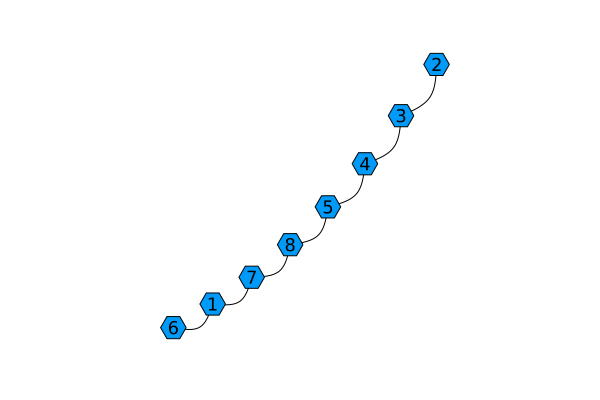

![](/assets/images/2826433329163121736.svg)

In [6]:
graph = LightGraphs.SimpleGraph(K)
for i in 1:length(genome)-k
    a_to_b_connection = genome[i:i+k]
    a = BioSequences.canonical(BioSequences.DNAMer(a_to_b_connection[1:end-1]))
    b = BioSequences.canonical(BioSequences.DNAMer(a_to_b_connection[2:end]))
    a_index = kmers[a].index
    b_index = kmers[b].index
    edge = LightGraphs.Edge(a_index, b_index)
    LightGraphs.add_edge!(graph, edge)
end

graph_hash = hash(sort(graph.fadjlist), hash(graph.ne))

p = GraphRecipes.graphplot(
    graph,
    names = 1:K,
    markersize = 0.15,
    hover=false,
    fontsize=12)

filename = "/assets/images/$(graph_hash).svg"
Plots.savefig(p, dirname(pwd()) * filename)
display(p)
display("text/markdown", "![]($filename)")

In this basic example, we can see that if we iterate through all kmer connections in our original dataset to determine the set of edges, we are able to resolve a single path that will reconstruct the original sequence.

```
6 <-> 1 <-> 7 <-> 8 <-> 5 <-> 4 <-> 3 <-> 2
```

While that sequence can be read in the forward or reverse-complement orientation (i.e. we can reverse the order in which we visit each node), that path visits each node at least once and in the fewest # of steps.
The length of the path will also generate a sequence equal to the length of our original genome.

The algorithmic runtime of assessing the edges of a given graph using the above framework is proportional to the size of the dataset:

$$\text{runtime} \propto (\text{# of observed sequences} * \text{length of sequences})$$

Determining the edges requires evaluating each pairwise kmer combination in the dataset, which we've already done (at least) once in order to count the kmers.

Some genome assemblers don't store the edges at all. Instead, the algorithms infer whether an edge could exist based on whether the two kmers are neighbors. We define "neighbors" as two kmers that can satisfy the condition
```
kmer_a[2:end] == kmer_b[1:end-1]
```

which is that the `k-1` length _suffix_ of `kmer_a` is equal to the `k-1` length _prefix_ of `kmer_b` where `kmer_a` and `kmer_b` can be in either forward or reverse_complement orientations

Below, we'll show the same dataset represented with a graph that explicitly stores all of the possible kmer connections that would be inferred as potentially existing in some frameworks

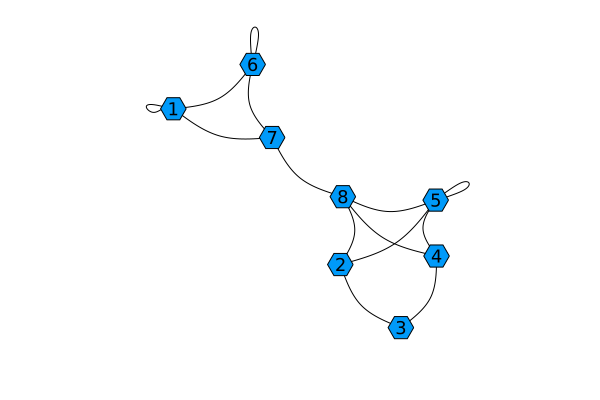

![](/assets/images/5348206229375442580.svg)

In [7]:
graph = LightGraphs.SimpleGraph(K)
for (index_a, fw_kmer) in enumerate(kmers.keys)
    for kmer in (fw_kmer, BioSequences.reverse_complement(fw_kmer))
        for neighbor in BioSequences.neighbors(kmer)
            canonical_neighbor = BioSequences.canonical(neighbor)
            index_b = get(kmers, canonical_neighbor, (index = 0, count = 0)).index
            if index_b != 0
                LightGraphs.add_edge!(graph, LightGraphs.Edge(index_a, index_b))
            end
        end
    end
end

graph_hash = hash(sort(graph.fadjlist), hash(graph.ne))

p = GraphRecipes.graphplot(
    graph,
    names = 1:K,
    markersize = 0.15,
    hover=false,
    fontsize=12)

filename = "/assets/images/$(graph_hash).svg"
Plots.savefig(p, dirname(pwd()) * filename)
display(p)
display("text/markdown", "![]($filename)")

As seen above in this simplified example, if we store all possible edges, we have the potential to add additional structural complexity to the graph that isn't supported by the data. As the size of the kmer increases, the likelihood that any two neighboring kmers could exist in a dataset _without_ being linked decreases asymptotically towards 0. With small kmer sizes and large datasets, however, the risk of falsely linking kmers could be very high as it is here.

Since we've already made the concession that we will only store and consider kmers that were actually observed to exist, rather than the list of kmers that _could_ exist, I would argue that we should only entertain edges that were also demonstrated to exist.